In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import random
import wandb
import torch.utils
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import os
import csv
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import scipy
import multiprocessing

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def resize_mel_spectrogram(mel_spec, target_shape):
    zoom_factors = (1, target_shape / mel_spec.shape[1])
    return scipy.ndimage.zoom(mel_spec, zoom_factors)

In [3]:
"""def normalize_decibel_spectrogram(spectrogram, target_min_db=0, target_max_db=100):
    # Calculate the minimum and maximum dB values in the input spectrogram
    min_db = np.min(spectrogram)
    max_db = np.max(spectrogram)
    # Perform min-max scaling to map the values to the target range
    normalized_spectrogram = (spectrogram - min_db) / (max_db - min_db) * (target_max_db - target_min_db) + target_min_db
    return normalized_spectrogram"""

'def normalize_decibel_spectrogram(spectrogram, target_min_db=0, target_max_db=100):\n    # Calculate the minimum and maximum dB values in the input spectrogram\n    min_db = np.min(spectrogram)\n    max_db = np.max(spectrogram)\n    # Perform min-max scaling to map the values to the target range\n    normalized_spectrogram = (spectrogram - min_db) / (max_db - min_db) * (target_max_db - target_min_db) + target_min_db\n    return normalized_spectrogram'

In [4]:
def normalize_mel_spectrogram(mel_spec_tensor):
    # Find the min and max values
    min_value = mel_spec_tensor.min()
    max_value = mel_spec_tensor.max()
    # Normalize the mel spectrogram tensor
    normalized_mel_spec = (mel_spec_tensor - min_value) / (max_value - min_value)
    return normalized_mel_spec

In [5]:
freq_min = 800
freq_max = 12000

In [6]:
class AudioClassificationDataset(Dataset):
    def __init__(self, data_dir, metadata_file, transform=None, batch_size=10):
        self.data_dir = data_dir
        self.metadata = self.extract_metadata(metadata_file)
        self.transform = transform
        self.batch_size = batch_size
        self.label_encoder = self.encode_labels(self.metadata['label'])
        
    # Itt tortenik a labelek es a hozzajuk tartozo fileok kiszedese a csv segitsegevel
    def extract_metadata(self, metadata_file):
        metadata_df = pd.read_csv(metadata_file)
        metadata_df['Filename'] = metadata_df['Filename'].apply(lambda x: x.split("/")[-1])
        metadata = metadata_df[['Label', 'Filename']]      
        metadata.columns = ['label', 'filename']
        return metadata

    def encode_labels(self,labels):
        unique_labels = labels.unique()
        encoded_dict = {label: num for label, num in zip(unique_labels, range(len(unique_labels)))}
        return encoded_dict
    
    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        label = self.metadata['label'][idx]
        filename = self.metadata['filename'][idx]
        audio_file = os.path.join(self.data_dir, label, filename)
        waveform, sample_rate = librosa.load(audio_file, sr=None)  
        mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, fmin=freq_min, fmax=freq_max)
        
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        #mel_spectrogram_db = normalize_decibel_spectrogram(mel_spectrogram_db)
        if mel_spectrogram_db.shape != 626:
                mel_spectrogram_db = resize_mel_spectrogram(mel_spectrogram_db, 626) 
        mel_spec_db_tensor = torch.from_numpy(mel_spectrogram_db).unsqueeze(0)
        mel_spec_db_tensor = normalize_mel_spectrogram(mel_spec_db_tensor)
        class_label = self.label_encoder[label]
        class_label_tensor = torch.tensor(class_label).unsqueeze(0)
        return mel_spec_db_tensor, class_label_tensor


In [7]:
def visualize_melspec(melspec, label):
    plt.figure(figsize=(10, 3))
    # Convert the tensorized melspec to a NumPy array if it's not already
    melspec = np.array(melspec)  
    # Loop over each spectrogram in the batch (assuming the first dimension is batch_size)
    for i in range(melspec.shape[0]):
        plt.subplot(1, melspec.shape[0], i + 1)
        
        # Display each spectrogram
        librosa.display.specshow(melspec[i], x_axis='time', y_axis='mel', sr=32000, cmap='viridis', fmin=freq_min, fmax=freq_max)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram from class {label.item()}')
    
    plt.tight_layout()
    plt.show()

In [8]:
def vizualize_waveform(waveform):
    plt.figure(figsize=(8, 3))
    librosa.display.waveshow(waveform, sr=32000)
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

In [9]:
def check_normalization(melspec):
    min_value = melspec.min().item()
    max_value = melspec.max().item()

    print(f"Min value: {min_value}")
    print(f"Max value: {max_value}")

    if min_value >= 0 and max_value <= 1:
        print("The mel spectrogram is normalized.")
    else:
        print("The mel spectrogram is not normalized.")

Size of the dataset:  11815


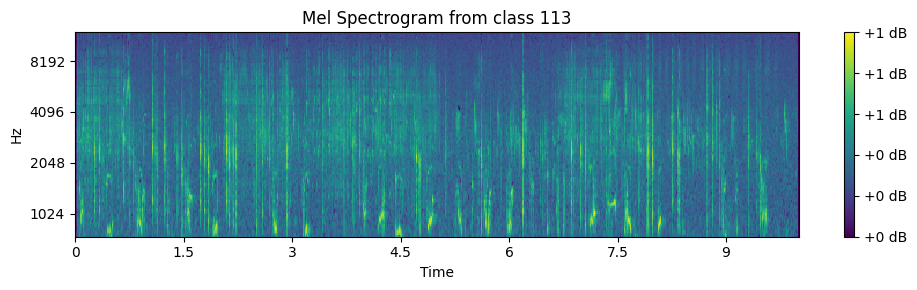

Min value: 0.0
Max value: 1.0
The mel spectrogram is normalized.
tensor([[[0.0009, 0.1890, 0.3223,  ..., 0.2930, 0.2125, 0.0009],
         [0.0009, 0.1927, 0.3607,  ..., 0.3211, 0.3067, 0.0009],
         [0.0009, 0.1681, 0.3977,  ..., 0.2361, 0.3089, 0.0009],
         ...,
         [0.0009, 0.0681, 0.2798,  ..., 0.2214, 0.2110, 0.0009],
         [0.0009, 0.0715, 0.2865,  ..., 0.2042, 0.1879, 0.0009],
         [0.0009, 0.0554, 0.2665,  ..., 0.2416, 0.1919, 0.0009]]])


In [10]:
data_dir = '/kaggle/input/birdclef-2023/train_audio'
metadata_file = '/kaggle/input/filtered-metadata/filtered_metadata.csv'
dataset = AudioClassificationDataset(data_dir, metadata_file)
print("Size of the dataset: ",len(dataset))
melspec, label = dataset[6000]
visualize_melspec(melspec, label)
check_normalization(melspec)
print(melspec)

In [11]:
class AudioClassifier(pl.LightningModule):
    def __init__(self, num_classes, droupout_rate = 0.5, learning_rate = 0.001, weight_decay = 0.01, optimizer= 'adamw'):
        super(AudioClassifier, self).__init__()  
       
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     #   self.conv4 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     #   self.conv5 = nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc1 = nn.Linear(256 * 16 * 78, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(droupout_rate)
        
        self.lr = learning_rate
        self.w_dec = weight_decay
        self.optimizer = optimizer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        num_features = x.size(1) * x.size(2) * x.size(3)
        x = x.view(-1, num_features)  # Reshape based on the calculated number of features
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()
        y_pred = self(x)
        train_loss = F.cross_entropy(y_pred, y)
        y_pred = torch.argmax(self(x), dim=1)
        train_acc = torch.sum(y_pred == y).item() / y.size(0)
        self.log('train_loss', train_loss.item(), on_epoch=True, on_step=True)
        self.log('train_acc', train_acc, on_epoch=True, on_step=True)
        print(f"Batch: {batch_idx}")
        print(f'Train loss: {train_loss.item()}')
        print(f'Train acc: {train_acc: .5f}')
        return train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()
        y_pred = self(x)
        val_loss = F.cross_entropy(y_pred, y)
        y_pred = torch.argmax(self(x), dim=1)
        val_acc = torch.sum(y_pred == y).item() / y.size(0)
        self.log('val_loss', val_loss.item(), on_epoch=True)
        self.log('val_acc', val_acc, on_epoch=True, )
        print(f"Batch: {batch_idx}")
        print(f'Val loss: {val_loss.item()}')
        print(f'Val acc: {val_acc: .5f}')
        return val_loss

    def configure_optimizers(self):
        if self.optimizer == "adamw":
            optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.w_dec)
        elif self.optimizer == "sgd":
            optimizer = optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.w_dec)
        elif self.optimizer == "rmsprop":
            optimizer = optim.RMSprop(self.parameters(), lr=self.lr, weight_decay=self.w_dec)
        return optimizer

In [12]:
# Define train, validation, and test split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

num_samples = len(dataset)
# Calculate the number of samples for each split
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

print(f'Training indicies: {num_train}  Validation indicies: {num_val}  Test indices: {num_test}')

# Randomly shuffle the dataset
indices = list(range(num_samples))
random.shuffle(indices)

# Split the dataset
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train + num_val]
test_indices = indices[-num_test:]

# Create data loaders for train, validation, and test sets
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

Training indicies: 8270  Validation indicies: 2363  Test indices: 1182


In [13]:
api_key = "4e488263381e934c7e9869882a816ddb6e6753ab"
wandb.login(key = api_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
def train():
    # Initialize WandB
    wandb.init()
    #config = wandb.config
    
    num_classes = 264
    
    train_loader = DataLoader(dataset, batch_size=config.batch_size, sampler=train_sampler, shuffle=False, num_workers=4)
    val_loader = DataLoader(dataset, batch_size=config.batch_size, sampler=val_sampler, shuffle=False, num_workers=4)
    test_loader = DataLoader(dataset, batch_size=config.batch_size, sampler=test_sampler)
    
    model = AudioClassifier(
        num_classes=num_classes,
        droupout_rate=config.dropout,
        learning_rate=config.lr,
        optimizer=config.optimizer,
        weight_decay =config.weight_decay, 
    )
    
    checkpoint_callback = ModelCheckpoint(
        monitor='val_acc',
        mode='max',
        filename='best_model',
        verbose=True,
        save_weights_only=True,
    )
    early_stopping_callback = pl.callbacks.EarlyStopping(monitor="val_acc", patience=3, verbose=False, mode="max")
    
    wandb_logger = WandbLogger(project=project_name, log_model='all')
    wandb_logger.watch(model,log_graph=False)
  
    # Initialize PyTorch Lightning Trainer
    trainer = pl.Trainer(accelerator='gpu',
                         max_epochs=10,
                         devices=1, 
                         precision="16-mixed",
                         logger=wandb_logger,
                         #strategy = 'auto',
                         callbacks=[checkpoint_callback, early_stopping_callback]
                        )

    # Train the model
    trainer.fit(model,train_loader,val_loader)
    wandb.finish()

In [15]:
project_name = 'deepbirding'
sweep_config = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'val_acc'
        },
    'parameters': {
        'lr': {'max': 1e-2, 'min': 1e-4},
        'optimizer': {'values': ['adamw', 'sgd', 'rmsprop']},
        'dropout': {'values': [0.4, 0.5, 0.6] },
        'batch_size': {'values': [16, 32, 64]},
        'weight_decay': {'max': 1e-1, 'min': 1e-3},
    }
}
sweep_id = wandb.sweep(sweep=sweep_config, project=project_name)
wandb.agent(sweep_id=sweep_id, function=train)

Create sweep with ID: bjjwg06k
Sweep URL: https://wandb.ai/deepbirding/deepbirding/sweeps/bjjwg06k


wandb: Agent Starting Run: b72ze5ou with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	lr: 0.008950893510377235
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.03057576109314112
wandb: Currently logged in as: bence-bihari99 (deepbirding). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231110_105051-b72ze5ou
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run daily-sweep-1
wandb: ⭐️ View project at https://wandb.ai/deepbirding/deepbirding
wandb: 🧹 View sweep at https://wandb.ai/deepbirding/deepbirding/sweeps/bjjwg06k
wandb: 🚀 View run at https://wandb.ai/deepbirding/deepbirding/runs/b72ze5ou
wandb: Waiting for W&B process to finish... (failed 1). Press Control-C to abort syncing.
wandb: 🚀 View run daily-sweep-1 at: https://wandb.ai/deepbirding/deep